In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os

In [2]:
DATASET_NAME = "sid321axn/beijing-multisite-airquality-data-set"
DOWNLOAD_DIR = os.path.join(os.getcwd(), 'data')


In [3]:
from utilities.data_util import fetch_data

fetch_data(DATASET_NAME, DOWNLOAD_DIR)


KAGGLE_CONFIG_DIR set to: /Users/serhanasad/Desktop/ML/final/4641_Group/secrets
Dataset URL: https://www.kaggle.com/datasets/sid321axn/beijing-multisite-airquality-data-set
Dataset downloaded and unzipped to /Users/serhanasad/Desktop/ML/final/4641_Group/Midterm/data
Created .gitignore in /Users/serhanasad/Desktop/ML/final/4641_Group/Midterm/data


In [4]:
data_folder = os.path.join(os.getcwd(), 'data')
print(os.getcwd())

print("data_folder", data_folder)
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

combined_data = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)


print("shape" ,combined_data.shape)

combined_data.to_csv(os.path.join(data_folder, 'combined_data.csv'), index=False)

/Users/serhanasad/Desktop/ML/final/4641_Group/Midterm
data_folder /Users/serhanasad/Desktop/ML/final/4641_Group/Midterm/data
shape (9677664, 18)


In [5]:
df = pd.read_csv("./data/combined_data.csv")

In [6]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [ ]:
df.drop(columns=["No", "station"], inplace=True, errors='ignore')


df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.set_index('datetime')

df["dow_sin"] = np.sin(2*np.pi * df.index.dayofweek / 7)
df["dow_cos"] = np.cos(2*np.pi * df.index.dayofweek / 7)
df["month_sin"] = np.sin(2*np.pi * (df.index.month-1) / 12)
df["month_cos"] = np.cos(2*np.pi * (df.index.month-1) / 12)
df['hour_sin'] = np.sin(2*np.pi * df.hour/24)
df['hour_cos'] = np.cos(2*np.pi * df.hour/24)





In [8]:
df = df.fillna(method='ffill').fillna(method='bfill')  # forward/backward fill
print("Values that are still missing", df.isnull().sum().sum())


/var/folders/m7/03m2hb3j4_3df05ypw6v1rvm0000gn/T/ipykernel_24912/981838099.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')  # forward/backward fill


Values that are still missing 0


In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
features = [c for c in numeric_cols]  # Exclude PM2.5 from features

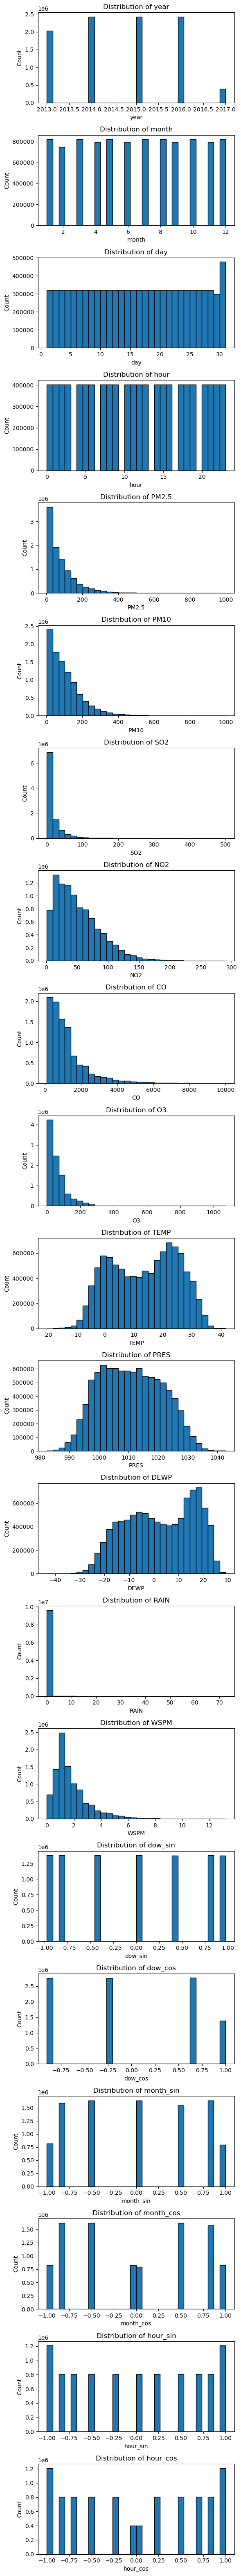

In [10]:
fig, axes = plt.subplots(len(features), 1, figsize=(6, 3 * len(features)))
for ax, col in zip(axes, features):
    ax.hist(df[col].dropna(), bins=30, edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

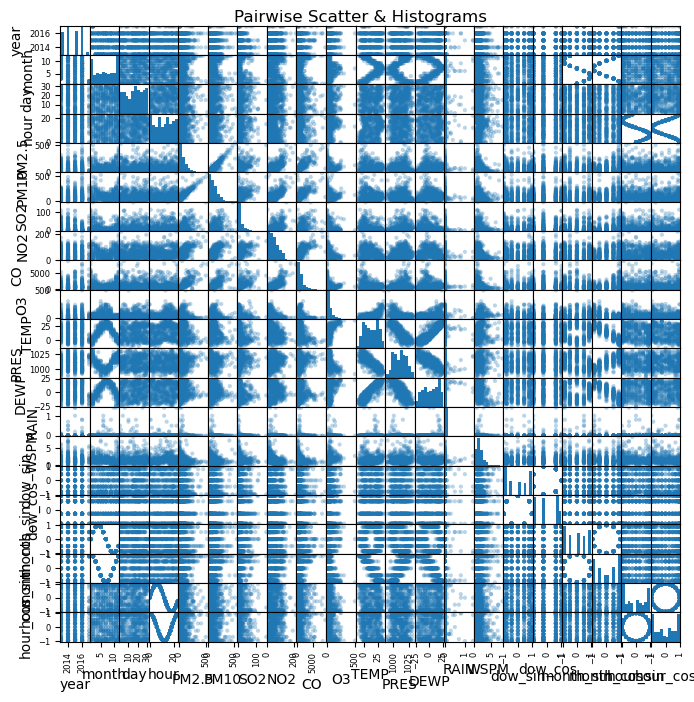

In [ ]:
from pandas.plotting import scatter_matrix

subset = df[features].sample(500, random_state=1)
fig = plt.figure(figsize=(8, 8))
axes = scatter_matrix(subset, alpha=0.3, diagonal='hist', figsize=(8, 8))
for ax in axes.flatten():
    ax.tick_params(labelsize=6)
plt.suptitle('Pairwise Scatter & Histograms', y=0.9)
plt.show()


/opt/anaconda3/envs/aqi_proj/lib/python3.12/site-packages/matplotlib/image.py:178: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


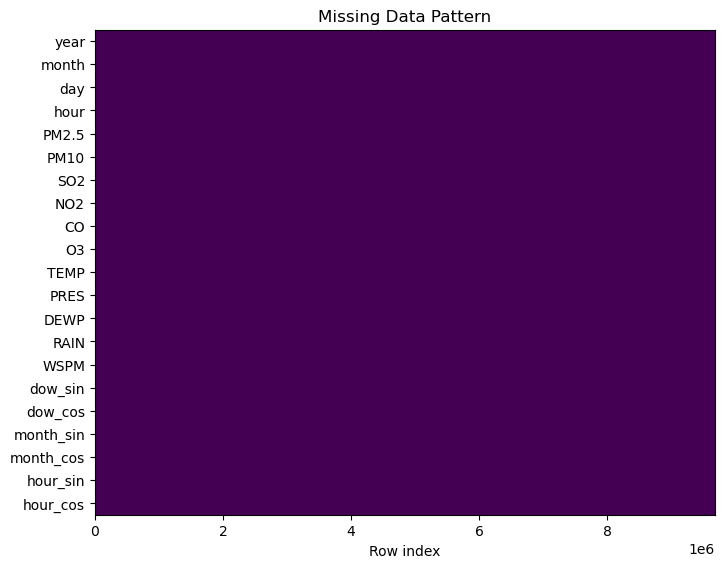

In [12]:
import numpy as np

mask = df[features].isnull().to_numpy().T
fig, ax = plt.subplots(figsize=(8, len(features) * 0.3))
ax.imshow(mask, aspect='auto', interpolation='none')
ax.set_yticks(np.arange(len(features)))
ax.set_yticklabels(features)
ax.set_xlabel('Row index')
ax.set_title('Missing Data Pattern')
plt.show()


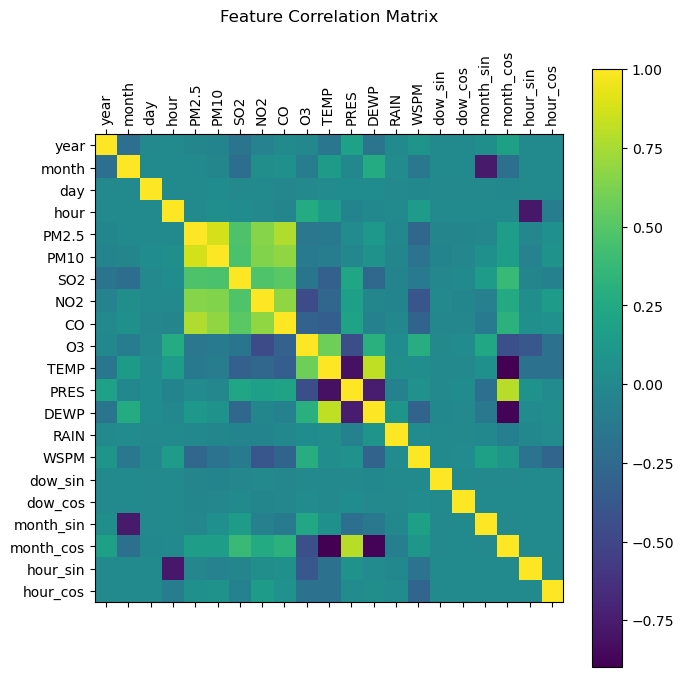

In [13]:
corr = df[features].corr()
fig, ax = plt.subplots(figsize=(7, 7))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=90)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_title('Feature Correlation Matrix', pad=20)
plt.tight_layout()
plt.show()


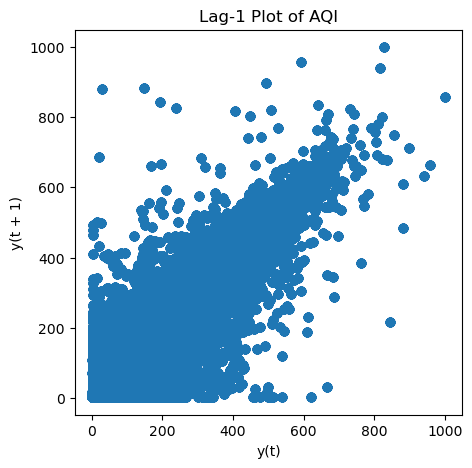

In [14]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots(figsize=(5, 5))
lag_plot(df['PM2.5'], lag=1, ax=ax)
ax.set_title('Lag‑1 Plot of AQI')
plt.show()


/opt/anaconda3/envs/aqi_proj/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


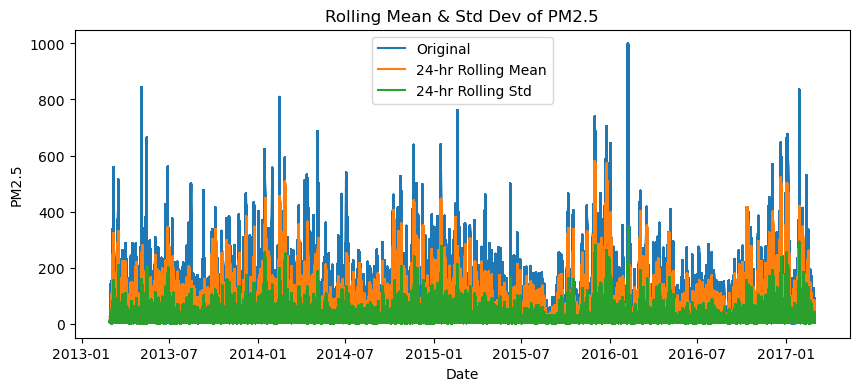

In [15]:
window = 24
rolling_mean = df['PM2.5'].rolling(window).mean()
rolling_std  = df['PM2.5'].rolling(window).std()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index, df['PM2.5'],      label='Original')
ax.plot(df.index, rolling_mean,   label=f'{window}-hr Rolling Mean')
ax.plot(df.index, rolling_std,    label=f'{window}-hr Rolling Std')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')
ax.set_title('Rolling Mean & Std Dev of PM2.5')
ax.legend()
plt.show()


In [ ]:
for col in ['PM2.5','PM10','CO','O3']:
    df[f'{col}_log'] = np.log1p(df[col])

for lag in [1,3,6,12]:
    df[f'PM2.5_lag{lag}'] = df['PM2.5'].shift(lag)

df['PM2.5_roll6']  = df['PM2.5'].rolling(6).mean()
df['PM2.5_roll24'] = df['PM2.5'].rolling(24).mean()
df['PM2.5_std24']  = df['PM2.5'].rolling(24).std()


In [17]:
print(len(df))

9677664


In [ ]:
from sklearn.preprocessing import MinMaxScaler

df = df.dropna().reset_index(drop=True)

split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

numeric_cols = train_df.select_dtypes(include=['int64','float64']).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in ['AQI']]


scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

print("Nans?", train_df[feature_cols].isna().any().any())
print("sample", train_df[feature_cols].head())


Any NaNs left in train? False
Train feature sample:
    year     month       day      hour     PM2.5      PM10       SO2       NO2  \
0   0.0  0.181818  0.000000  1.000000  0.014042  0.026078  0.027444  0.065658   
1   0.0  0.181818  0.033333  0.000000  0.012036  0.016048  0.047456  0.145250   
2   0.0  0.181818  0.033333  0.043478  0.016048  0.037111  0.049457  0.093342   
3   0.0  0.181818  0.033333  0.086957  0.017051  0.027081  0.059463  0.041435   
4   0.0  0.181818  0.033333  0.130435  0.013039  0.022066  0.039451  0.037974   

         CO        O3  ...  PM10_log    CO_log    O3_log  PM2.5_lag1  \
0  0.101010  0.040891  ...  0.390537  0.519845  0.532577    0.014042   
1  0.131212  0.023147  ...  0.317745  0.572127  0.451706    0.014042   
2  0.121212  0.034354  ...  0.445895  0.556168  0.507652    0.012036   
3  0.101010  0.043693  ...  0.396373  0.519845  0.542092    0.016048   
4  0.090909  0.042759  ...  0.364987  0.499124  0.538988    0.017051   

   PM2.5_lag3  PM2.5_lag6  

In [19]:
print(train_df[feature_cols])

         year     month       day      hour     PM2.5      PM10       SO2  \
0        0.00  0.181818  0.000000  1.000000  0.014042  0.026078  0.027444   
1        0.00  0.181818  0.033333  0.000000  0.012036  0.016048  0.047456   
2        0.00  0.181818  0.033333  0.043478  0.016048  0.037111  0.049457   
3        0.00  0.181818  0.033333  0.086957  0.017051  0.027081  0.059463   
4        0.00  0.181818  0.033333  0.130435  0.013039  0.022066  0.039451   
...       ...       ...       ...       ...       ...       ...       ...   
7742107  0.75  0.363636  0.366667  0.782609  0.001003  0.003009  0.003431   
7742108  0.75  0.363636  0.366667  0.826087  0.001003  0.069208  0.003431   
7742109  0.75  0.363636  0.366667  0.869565  0.001003  0.110331  0.003431   
7742110  0.75  0.363636  0.366667  0.913043  0.005015  0.082247  0.003431   
7742111  0.75  0.363636  0.366667  0.956522  0.006018  0.101304  0.003431   

              NO2        CO        O3  ...  PM10_log    CO_log    O3_log  \

In [20]:
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

X_train_arr = train_df[feature_cols].values.astype(np.float32)
y_train_arr = train_df['PM2.5'].values.astype(np.float32)
X_val_arr   = test_df[feature_cols].values.astype(np.float32)
y_val_arr   = test_df['PM2.5'].values.astype(np.float32)

seq_len    = 48
batch_size = 64

train_gen = TimeseriesGenerator(
  X_train_arr, y_train_arr,
  length=seq_len,
  sampling_rate=1,    
  stride=6,        
  batch_size=64
)

val_gen = TimeseriesGenerator(
    X_val_arr, y_val_arr,
    length=seq_len,
    batch_size=batch_size
)


def weighted_mse(y_true, y_pred):
    weights = 1 + 3 * K.square(y_true)
    return K.mean(weights * K.square(y_pred - y_true))

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res/(ss_tot + K.epsilon())


n_feats = X_train_arr.shape[1]  

inputs = Input(shape=(seq_len, n_feats))
x = LSTM(
    64,
    return_sequences=True,
    kernel_regularizer=l2(1e-3),
    recurrent_regularizer=l2(1e-3),
    dropout=0.2,
    recurrent_dropout=0.2
)(inputs)
x = LSTM(
    32,
    kernel_regularizer=l2(1e-3),
    recurrent_regularizer=l2(1e-3),
    dropout=0.2,
    recurrent_dropout=0.2
)(x)
x = Dropout(0.3)(x)
outputs = Dense(
    1,
    activation="linear",
    kernel_regularizer=l2(1e-3)
)(x)

model = Model(inputs, outputs)

import tensorflow as tf
optimizer  = tf.keras.optimizers.Adam(learning_rate=0.003)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(
    optimizer=optimizer,
    loss=weighted_mse,
    metrics=['mae', r2_keras]
)

history = model.fit(
  train_gen,
  validation_data=val_gen,
  epochs=9,
  steps_per_epoch=2000,    
  validation_steps=500,    
  callbacks=[early_stop]
)


Epoch 1/9


/opt/anaconda3/envs/aqi_proj/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 98s 48ms/step - loss: 0.0347 - mae: 0.0486 - r2_keras: -148.3776 - val_loss: 0.0043 - val_mae: 0.0354 - val_r2_keras: -231205.4062
Epoch 2/9
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - loss: 0.0045 - mae: 0.0368 - r2_keras: -110.8767 - val_loss: 0.0040 - val_mae: 0.0369 - val_r2_keras: -626636.7500
Epoch 3/9
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 96s 48ms/step - loss: 0.0039 - mae: 0.0344 - r2_keras: -112.8704 - val_loss: 0.0034 - val_mae: 0.0295 - val_r2_keras: -34504.1797
Epoch 4/9
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 97s 48ms/step - loss: 0.0036 - mae: 0.0330 - r2_keras: -115.1123 - val_loss: 0.0032 - val_mae: 0.0251 - val_r2_keras: -92657.4766
Epoch 5/9
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 96s 48ms/step - loss: 0.0036 - mae: 0.0331 - r2_keras: -115.9283 - val_loss: 0.0027 - val_mae: 0.0243 - val_r2_keras: -126161.9297
Epoch 6/9
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 96s 48ms/step - loss: 0.0034 - mae: 0.0316 - r2_keras: -115.7010 - val_loss: 0.0028 - val_mae: 0.0244 - val_r2_

500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
MAE:  0.0232
RMSE: 0.0357
R²:   0.8216


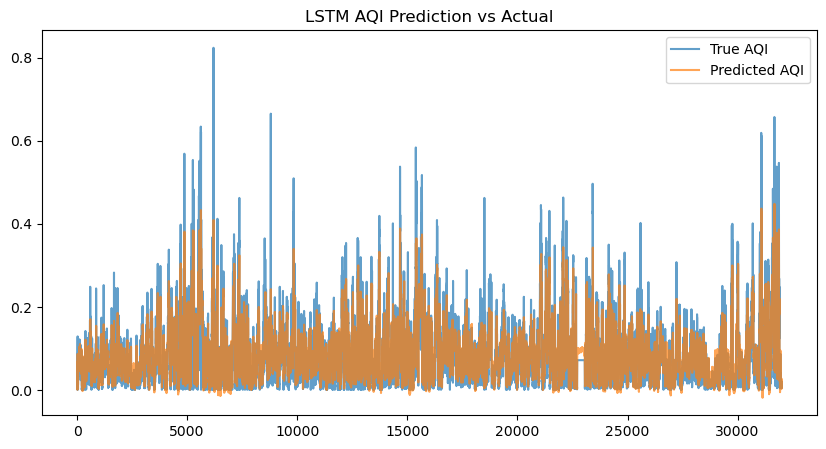

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(val_gen, steps=500, verbose=1)

n = 500 * batch_size
y_true = y_val_arr[seq_len : seq_len + n]


mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_true, label='True AQI', alpha=0.7)
plt.plot(y_pred, label='Predicted AQI', alpha=0.7)
plt.title('LSTM AQI Prediction vs Actual')
plt.legend()
plt.show()


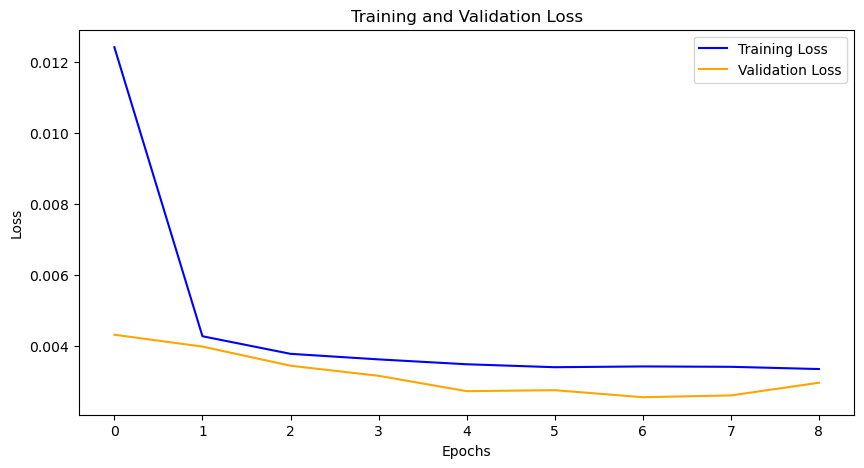

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

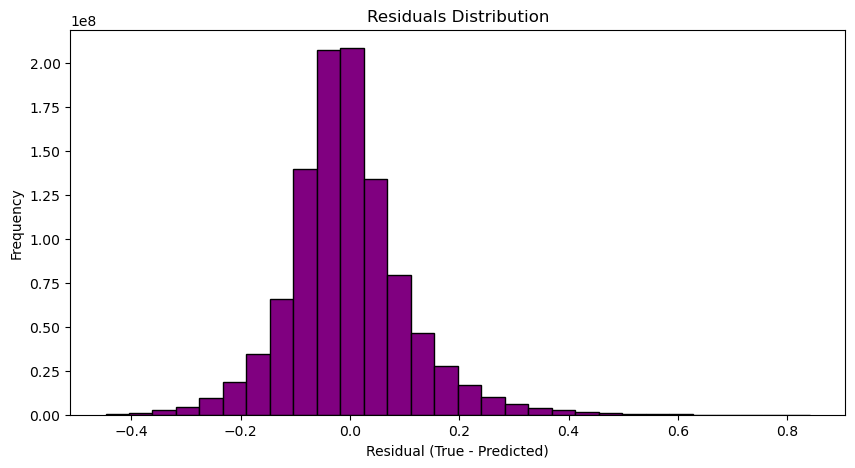

In [28]:
# Calculate residuals
residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals.flatten(), bins=30, edgecolor='black', color='purple')  # Flatten residuals to 1D
plt.title('Residuals Distribution')
plt.xlabel('Residual (True - Predicted)')
plt.ylabel('Frequency')
plt.show()

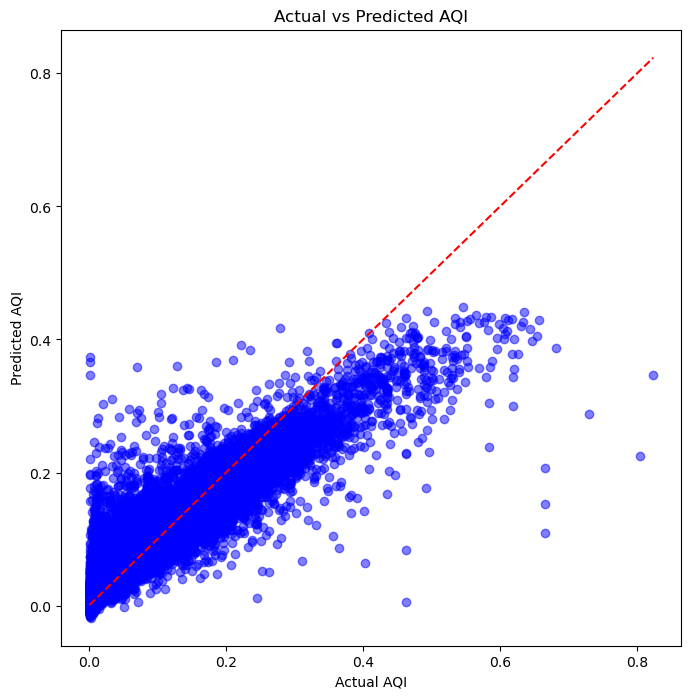

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='red')  # Perfect prediction line
plt.title('Actual vs Predicted AQI')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.show()